# Test Set Analysis, Financial Insights, and Delivery to the Client



In [1]:
#Setup
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400 #high res figures
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import shap
import pickle

In [2]:
with open('/home/joseph/python_projects/Activity_6_01_data.pkl', 'rb') as f:
    features_response, X_train_all, y_train_all, X_test_all,\
    y_test_all = pickle.load(f)

In [3]:
#Define Validation set to train XGBoost with early Stopping

from sklearn.model_selection import train_test_split
X_train_2, X_val_2, y_train_2, y_val_2 = \
train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=24)

xgb_model_4 = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=0,
    learning_rate=0.1,
    verbosity=1,
    objective='binary:logistic',
    use_label_encoder=False,
    n_jobs=-1,
    tree_method='hist',
    grow_policy='lossguide')

max_leaves_values = list(range(5,205,5))
print(max_leaves_values[:5])
print(max_leaves_values[-5:])

eval_set_2 = [(X_train_2, y_train_2), (X_val_2, y_val_2)]

[5, 10, 15, 20, 25]
[180, 185, 190, 195, 200]


`use_label_encoder` is deprecated in 1.7.0.


In [4]:
%%time
val_aucs = []
for max_leaves in max_leaves_values:
    #Set parameter and fit model
    xgb_model_4.set_params(**{'max_leaves':max_leaves})
    xgb_model_4.fit(X_train_2, y_train_2, eval_set=eval_set_2,
                  eval_metric='auc',
                  verbose=False, early_stopping_rounds=30)
    
    #Get validation score
    val_set_pred_proba = xgb_model_4.predict_proba(X_val_2)[:,1]
    val_aucs.append(roc_auc_score(y_val_2, val_set_pred_proba))

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

CPU times: user 7min 9s, sys: 9.28 s, total: 7min 19s
Wall time: 1min 3s


<AxesSubplot:xlabel='Max leaves'>

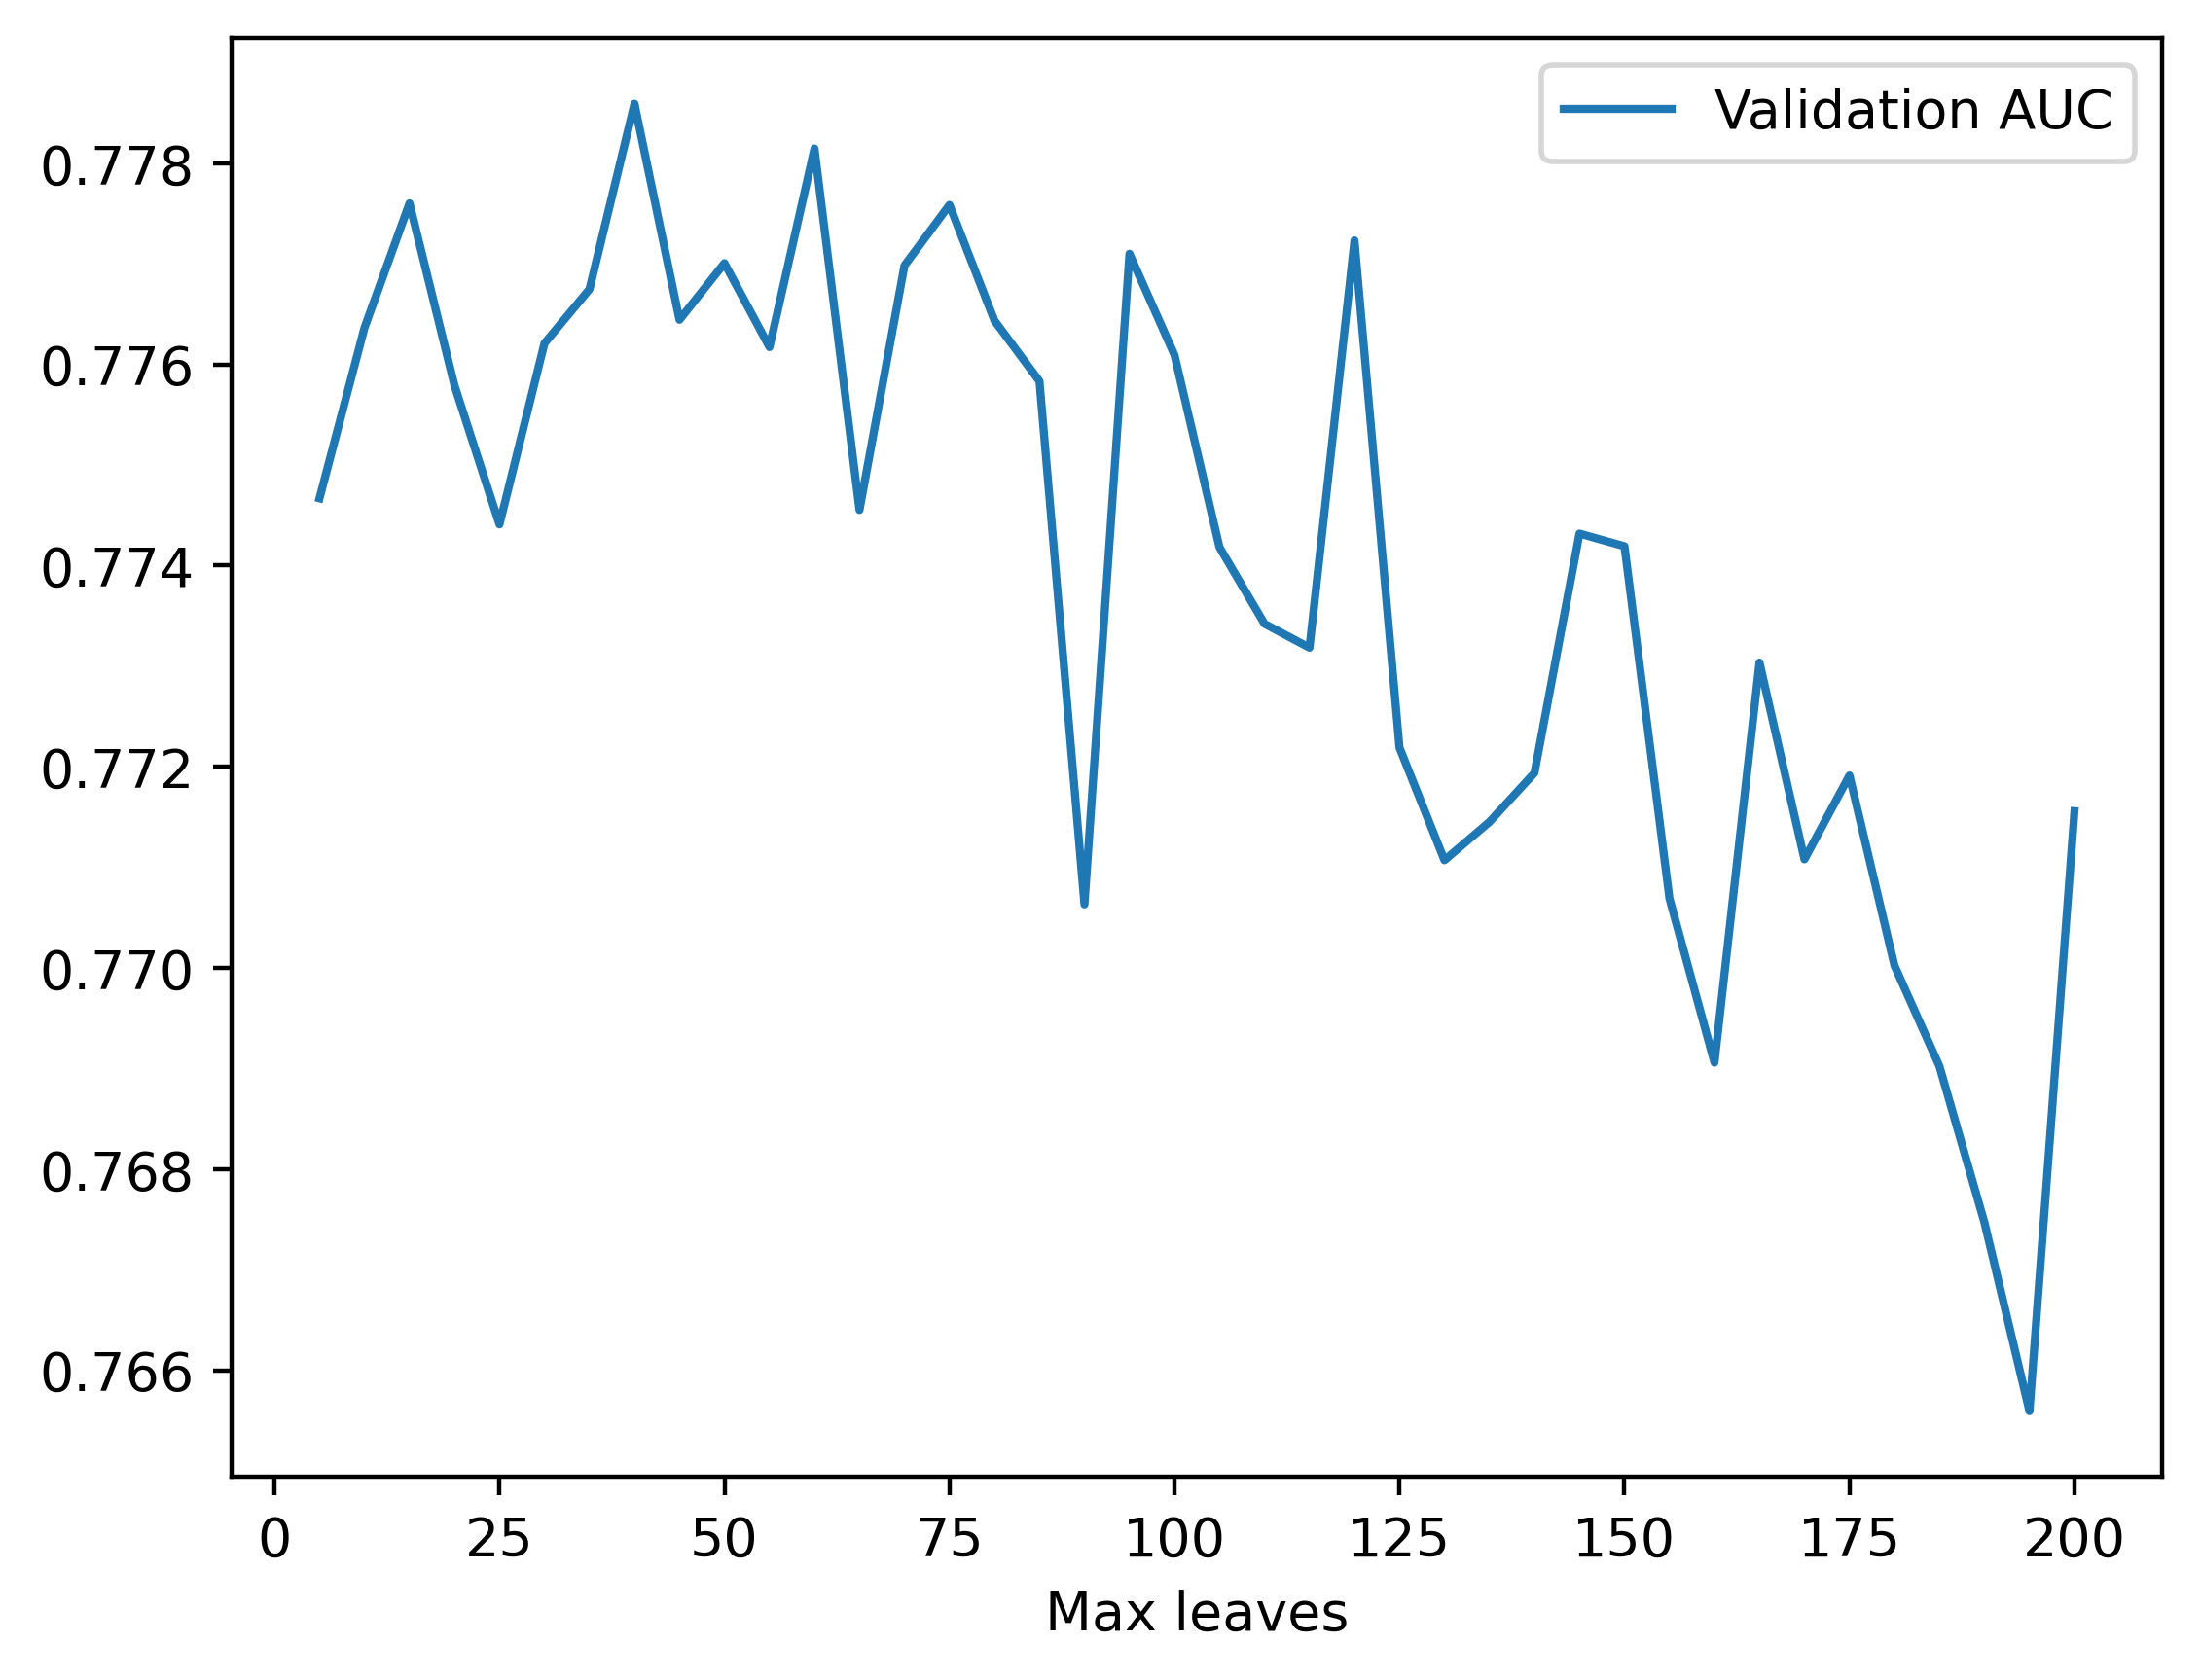

In [6]:
#Plot Validation AUC vs Max Leaves
max_leaves_df_2 = pd.DataFrame({'Max leaves':max_leaves_values,'Validation AUC':val_aucs})

mpl.rcParams['figure.dpi'] = 400
max_leaves_df_2.set_index('Max leaves').plot()

In [7]:
max_auc_2 = max_leaves_df_2['Validation AUC'].max()
max_auc_2

0.7785918508068121

In [8]:
max_ix_2 = max_leaves_df_2['Validation AUC'] == max_auc_2
max_leaves_df_2[max_ix_2]

,Max leaves,Validation AUC
7,40,0.778592


In [9]:
#Retrain with optimal hyperparameter
xgb_model_4.set_params(**{'max_leaves':40})
xgb_model_4.fit(X_train_2, y_train_2, eval_set=eval_set_2,
              eval_metric='auc',
              verbose=False, early_stopping_rounds=30)

X_val_2_df = pd.DataFrame(data=X_val_2, columns=features_response[:-1])


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


In [10]:
#SHAP
%time explainer_2 = shap.explainers.Tree(xgb_model_4, data=X_val_2_df)

CPU times: user 138 ms, sys: 4.18 ms, total: 143 ms
Wall time: 140 ms


In [11]:
%time shap_values_2 = explainer_2(X_val_2_df)

 95%|=================== | 4491/4750 [00:13<00:00]       

CPU times: user 13.5 s, sys: 50.3 ms, total: 13.5 s
Wall time: 13.5 s


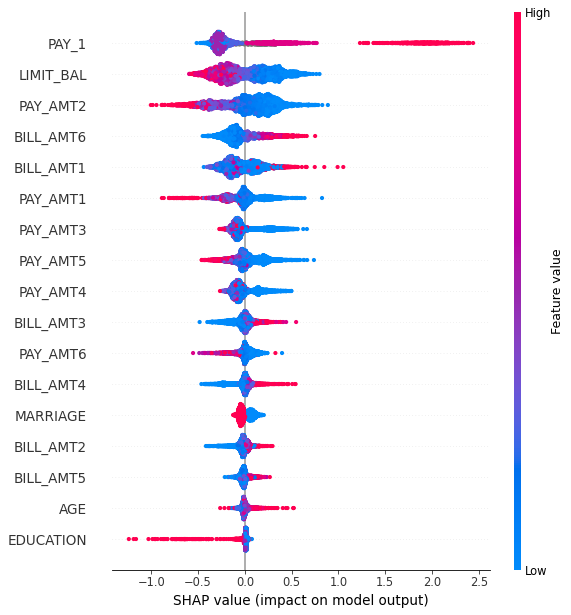

CPU times: user 777 ms, sys: 8.19 ms, total: 785 ms
Wall time: 783 ms


In [12]:
%%time
mpl.rcParams['figure.dpi'] = 75
shap.summary_plot(shap_values_2.values, X_val_2_df)

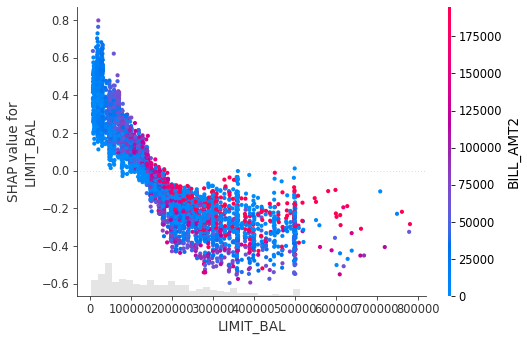

In [13]:
shap.plots.scatter(shap_values_2[:,'LIMIT_BAL'],
                   color=shap_values_2)

## Chapter 8 Proper: Begin!

In [14]:
with open('/home/joseph/python_projects/Activity_6_01_data.pkl', 'rb') as f:
    features_response, X_train_all, y_train_all, X_test_all,\
    y_test_all = pickle.load(f)

In [15]:
#Make Predictions for test set
test_set_pred_proba = xgb_model_4.predict_proba(X_test_all)[:,1]

from sklearn.metrics import roc_auc_score
test_auc = roc_auc_score(y_test_all, test_set_pred_proba)
test_auc

0.7735528979671706

Text(0.5, 1.0, 'Distribution of Predicted Probabilities')

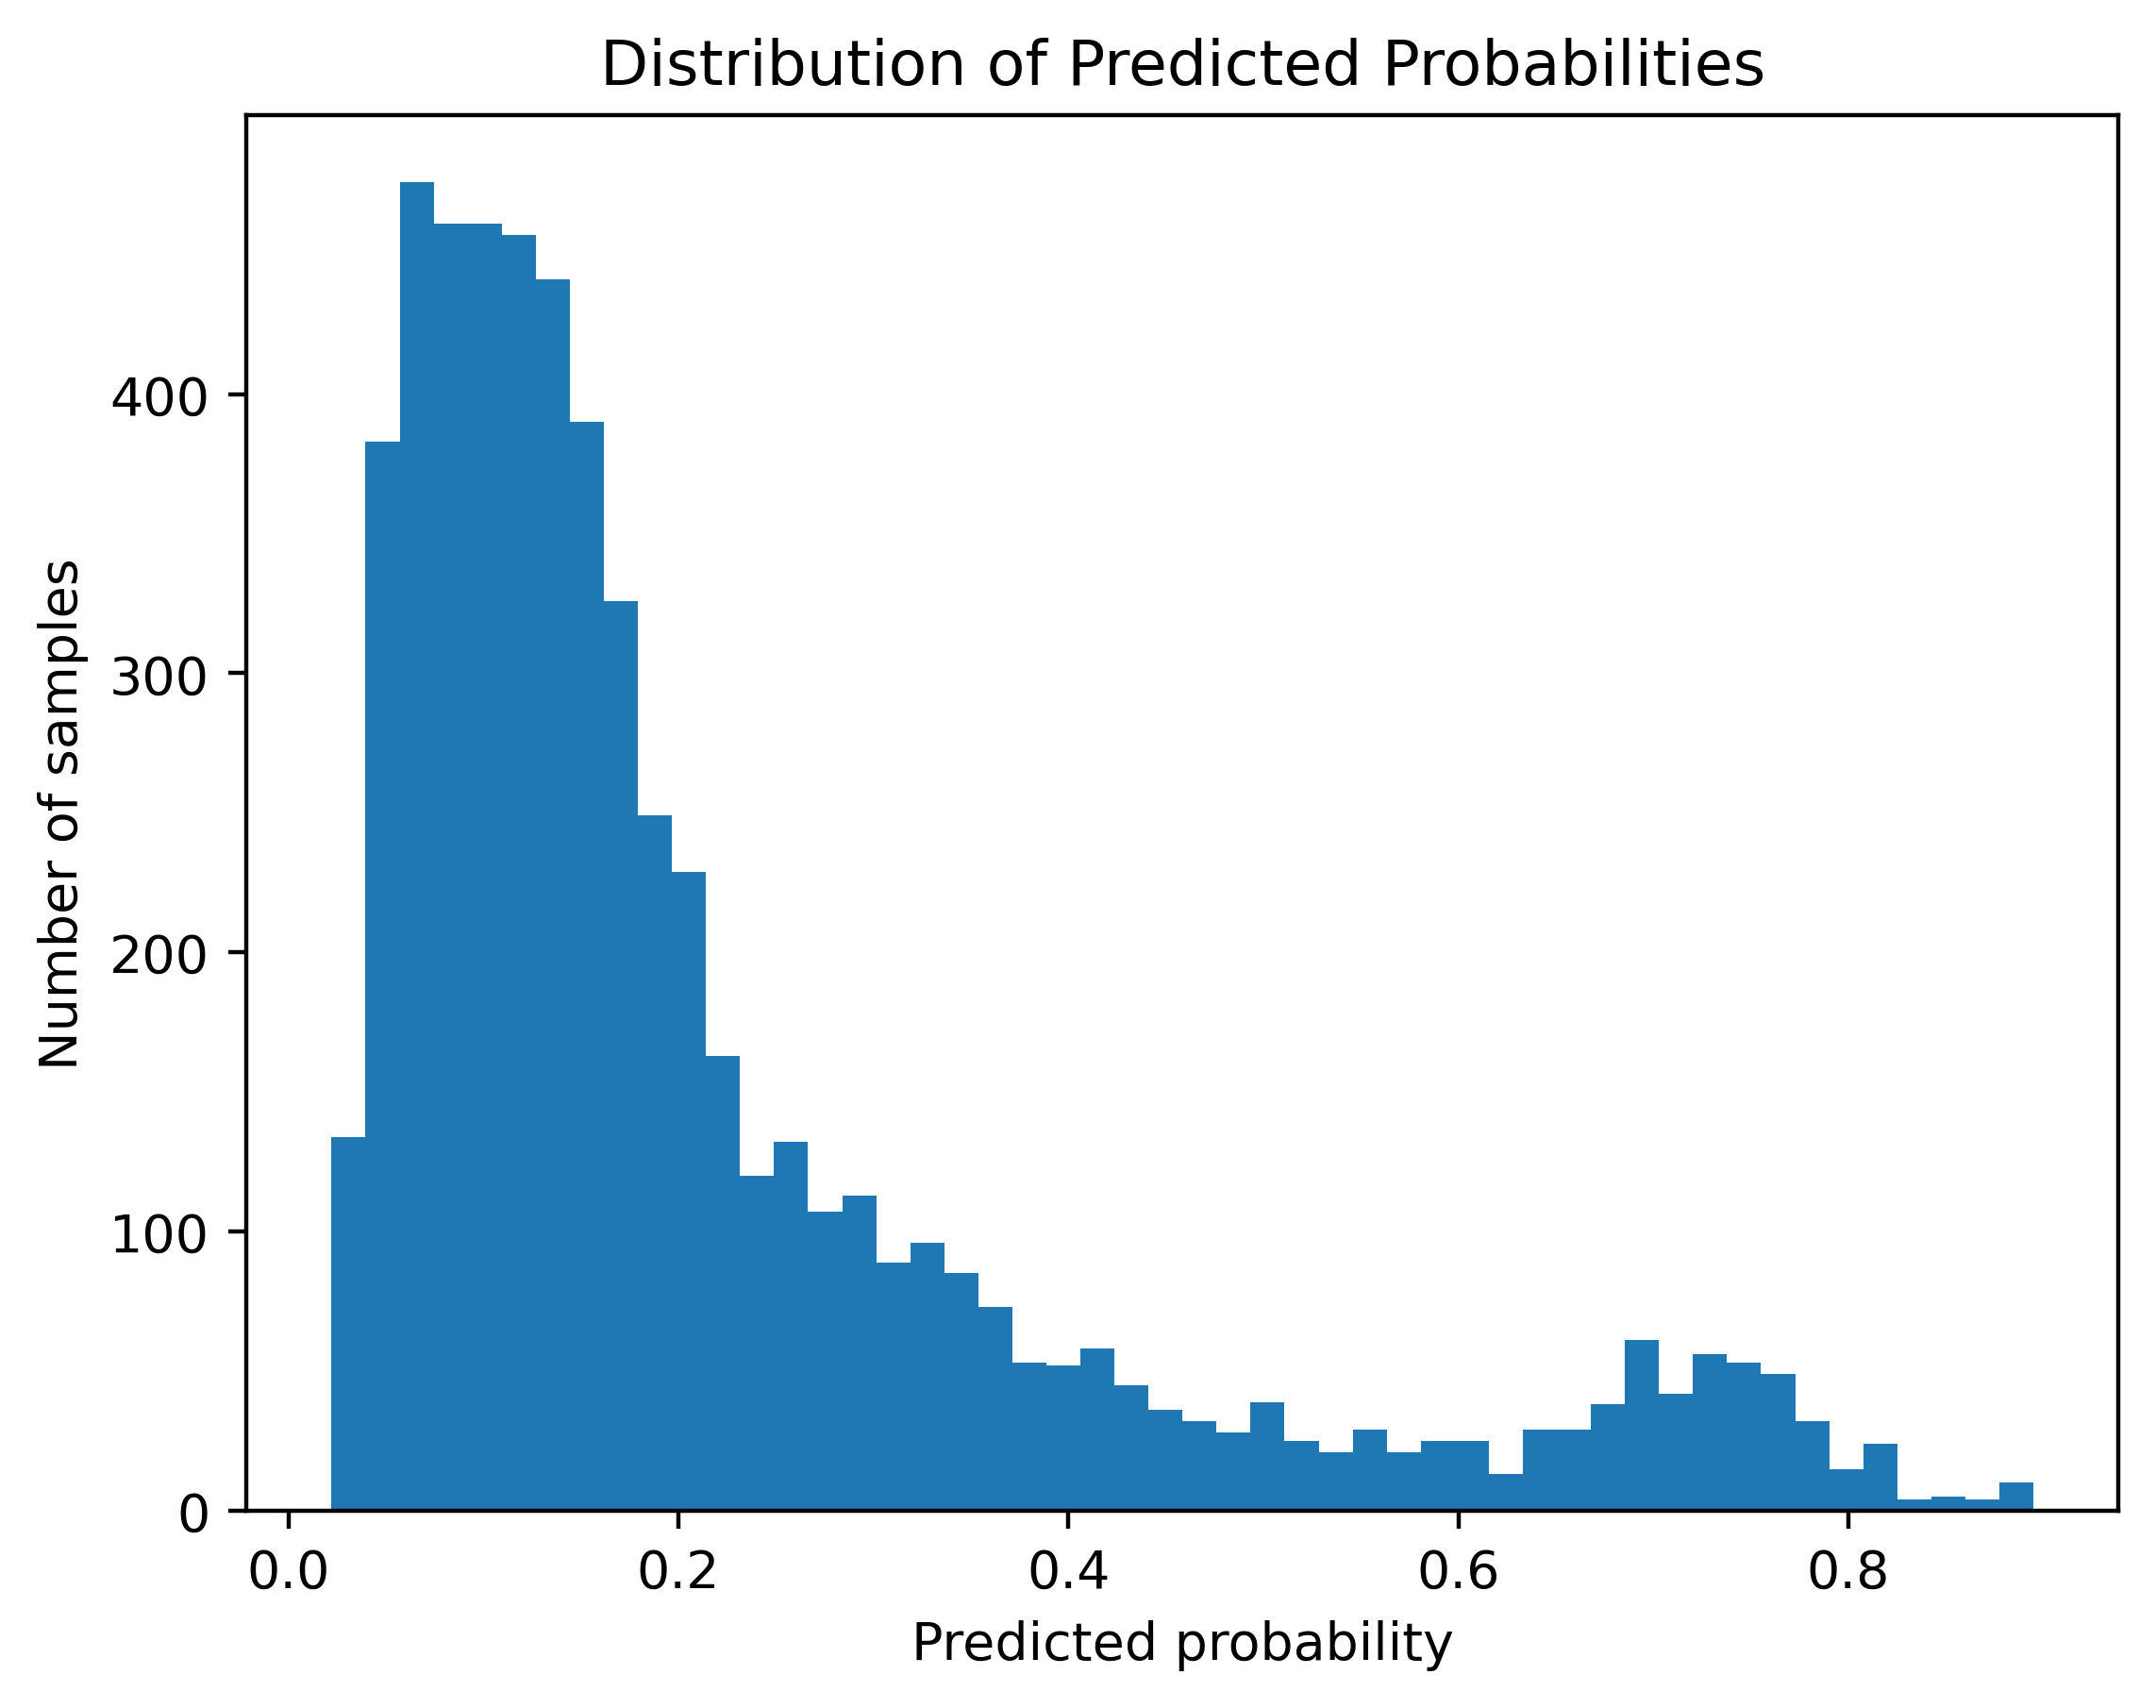

In [17]:
#Plot
mpl.rcParams['figure.dpi'] = 400
plt.hist(test_set_pred_proba, bins=50)
plt.xlabel('Predicted probability')
plt.ylabel('Number of samples')
plt.title('Distribution of Predicted Probabilities')

In [18]:
#Create a Decile chart
deciles, decile_bin_edges = pd.qcut(x=test_set_pred_proba,q=10,retbins=True)
decile_bin_edges #We need 10 bins

array([0.02213463, 0.06000734, 0.08155108, 0.10424594, 0.12708404,
       0.15019046, 0.18111563, 0.23032923, 0.32210371, 0.52585585,
       0.89491451])

In [19]:
#Combine decile with true labels of test set and the predicted probabilities
test_set_df = pd.DataFrame({'Predicted probability':test_set_pred_proba,\
'Prediction decile':deciles,'Outcome':y_test_all})
test_set_df.head()

,Predicted probability,Prediction decile,Outcome
0,0.544556,"(0.526, 0.895]",0
1,0.621311,"(0.526, 0.895]",0
2,0.049883,"(0.0211, 0.06]",0
3,0.890924,"(0.526, 0.895]",1
4,0.272326,"(0.23, 0.322]",0


In [20]:
#Find the true Default Rate within the decile bins
test_set_gr = test_set_df.groupby('Prediction decile')

#Count of data in each bin
gr_df = test_set_gr.agg({'Outcome':['count', 'mean']})

In [21]:
gr_df

Outcome          
                    count      mean
Prediction decile                  
(0.0211, 0.06]        594  0.045455
(0.06, 0.0816]        594  0.070707
(0.0816, 0.104]       594  0.099327
(0.104, 0.127]        593  0.112985
(0.127, 0.15]         594  0.116162
(0.15, 0.181]         594  0.171717
(0.181, 0.23]         593  0.195616
(0.23, 0.322]         594  0.282828
(0.322, 0.526]        594  0.392256
(0.526, 0.895]        594  0.676768

In [22]:
gr_df.columns

MultiIndex([('Outcome', 'count'),
            ('Outcome',  'mean')],
           )

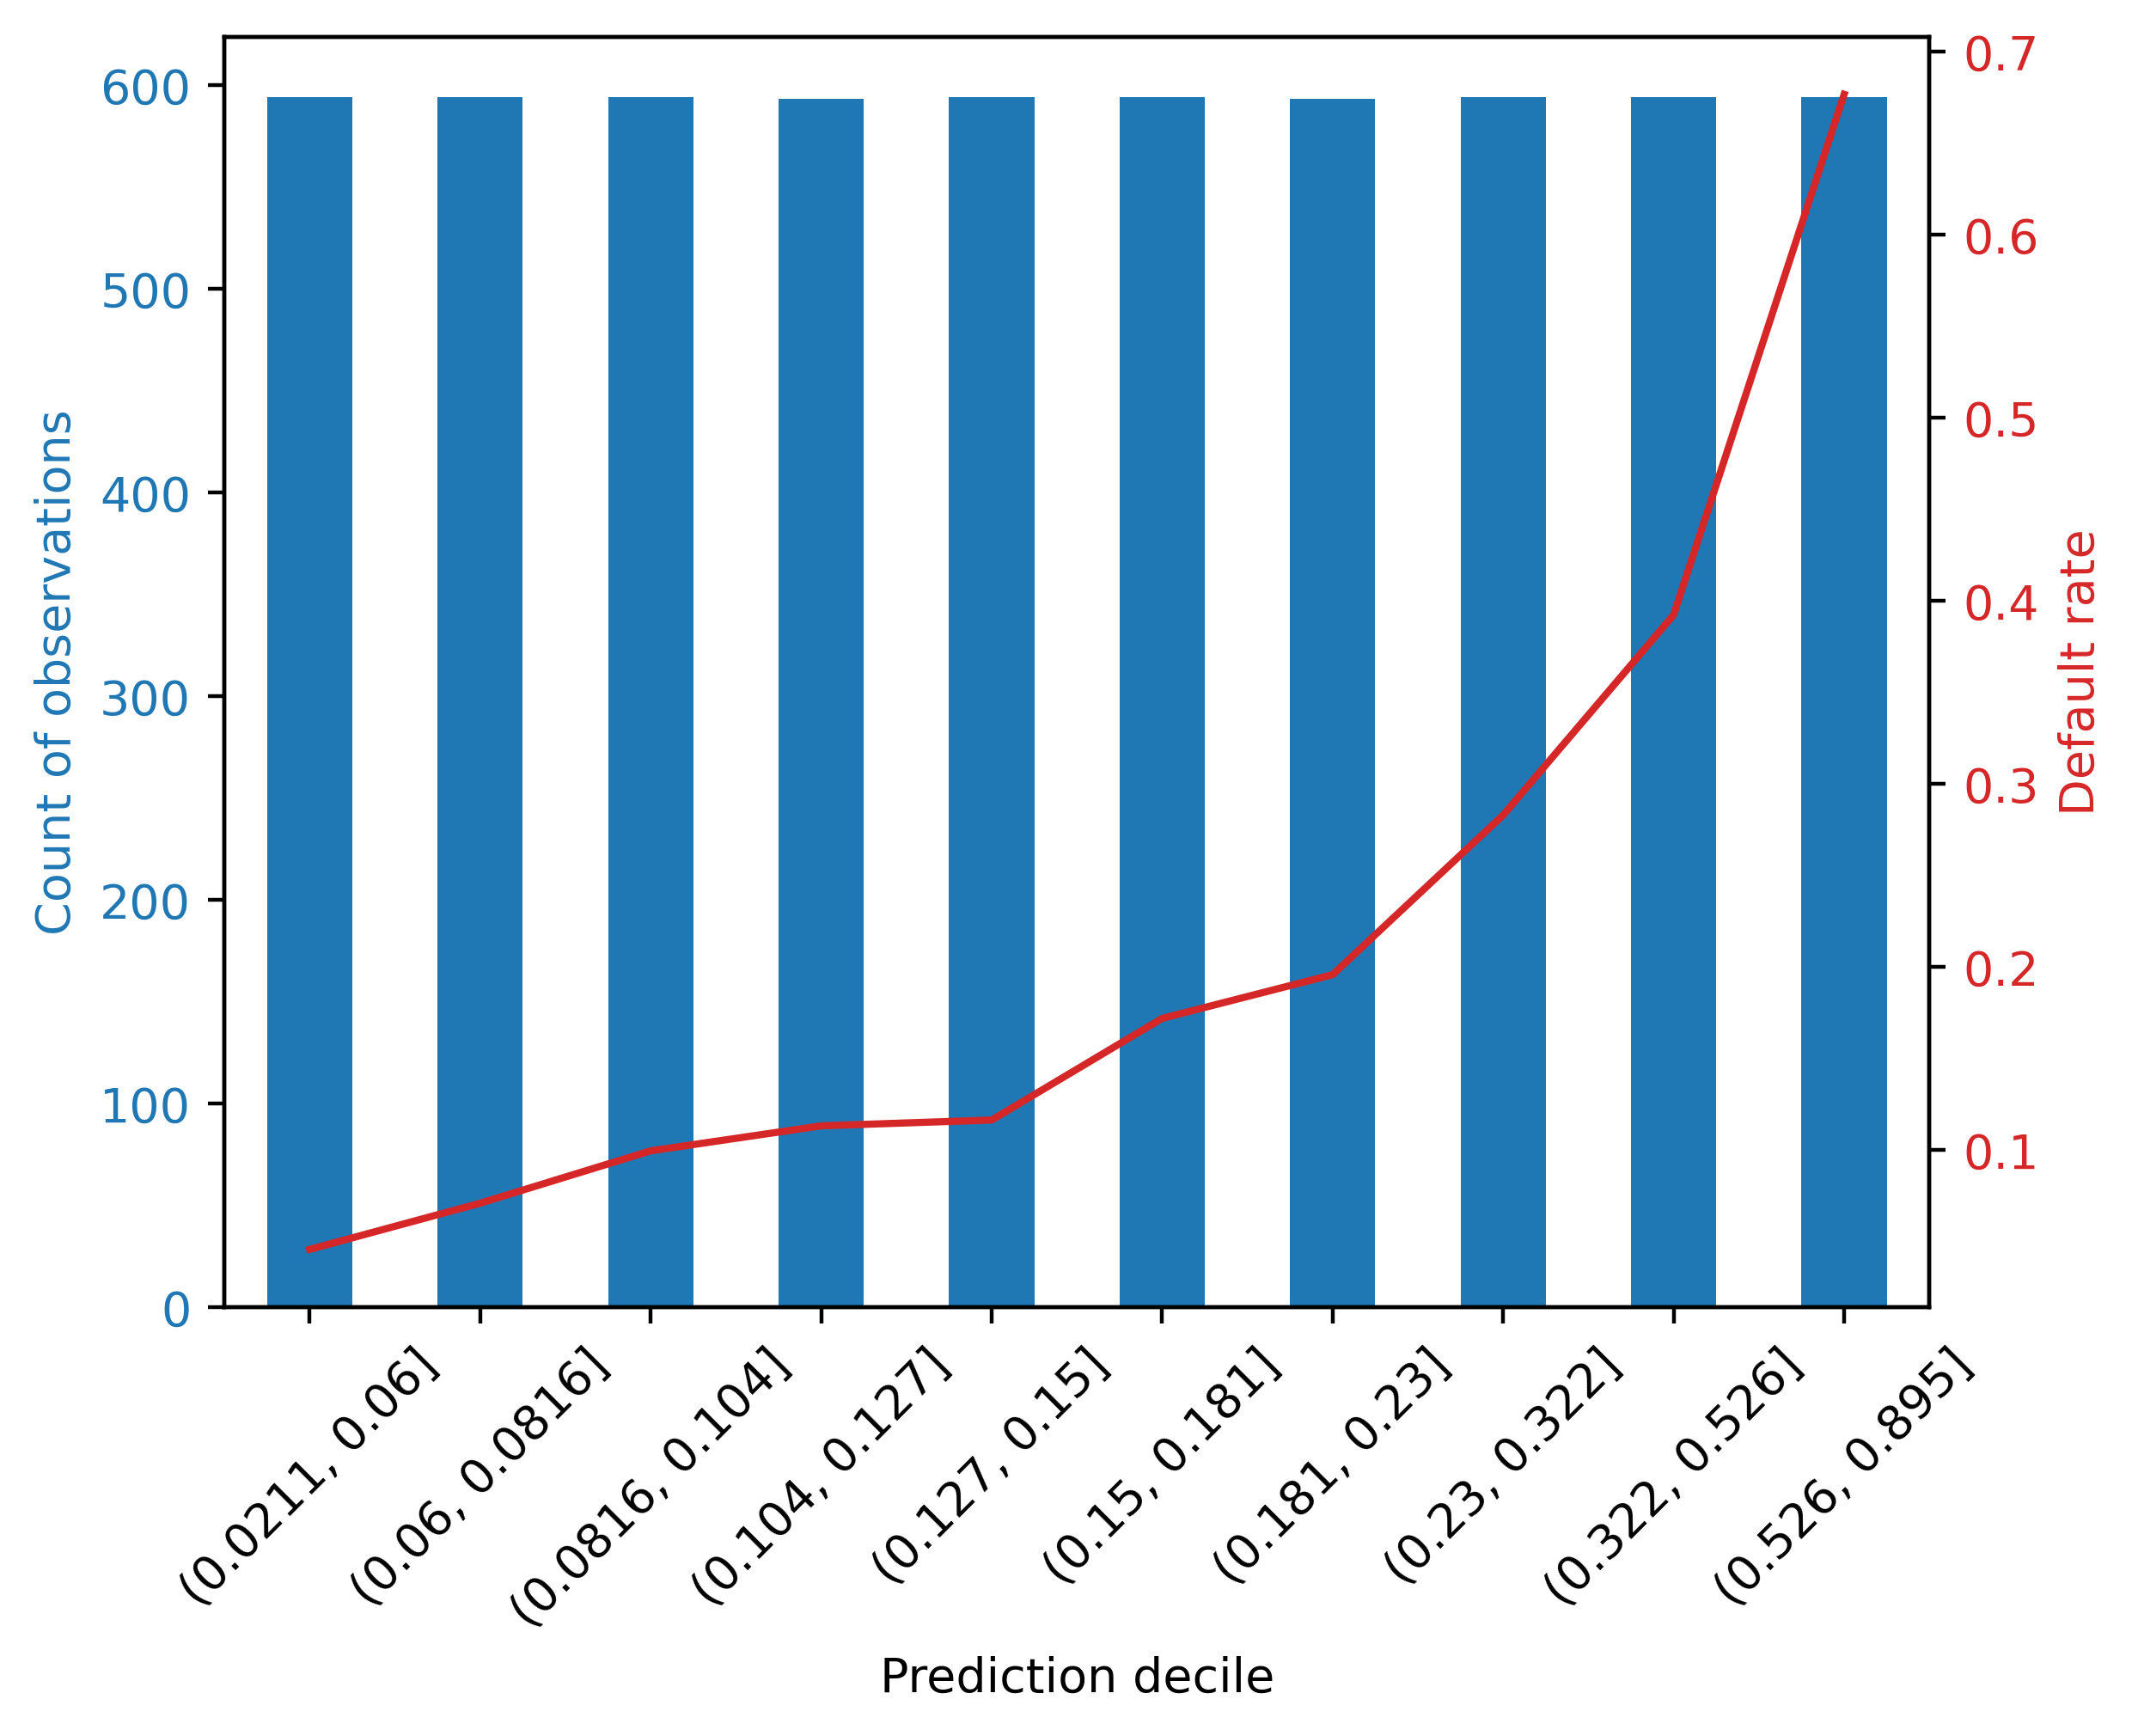

In [25]:
#Plots
ax_1 = plt.axes()
color_1 = 'tab:blue'
gr_df[('Outcome', 'count')].plot.bar(ax=ax_1, color=color_1)
ax_1.set_ylabel('Count of observations', color=color_1)
ax_1.tick_params(axis='y', labelcolor=color_1)
ax_1.tick_params(axis='x', labelrotation = 45)

ax_2 = ax_1.twinx()
color_2 = 'tab:red'
gr_df[('Outcome', 'mean')].plot(ax=ax_2, color=color_2)
ax_2.set_ylabel('Default rate', color=color_2)
ax_2.tick_params(axis='y', labelcolor=color_2)

## Creating Error Bars

In [26]:
#Equal-interval labels for 5 bins
equal_intervals, equal_interval_bin_edges = pd.cut(x=test_set_pred_proba,bins=5,retbins=True)

In [27]:
equal_interval_bin_edges

array([0.02126185, 0.1966906 , 0.37124658, 0.54580256, 0.72035853,
       0.89491451])

In [28]:
equal_interval_bin_edges[1:] - equal_interval_bin_edges[:-1] #Interval between bin edges

array([0.17542876, 0.17455598, 0.17455598, 0.17455598, 0.17455598])

In [29]:
#Test Set Bins Dataframe
test_set_bins_df =pd.DataFrame({'Predicted probability':test_set_pred_proba,\
'Prediction bin':equal_intervals,'Outcome':y_test_all})
test_set_bins_df.head()

,Predicted probability,Prediction bin,Outcome
0,0.544556,"(0.371, 0.546]",0
1,0.621311,"(0.546, 0.72]",0
2,0.049883,"(0.0213, 0.197]",0
3,0.890924,"(0.72, 0.895]",1
4,0.272326,"(0.197, 0.371]",0


In [30]:
#Group by bin label and calculate default rate and sample count within bins
test_set_equal_gr = test_set_bins_df.groupby('Prediction bin')
gr_eq_df = test_set_equal_gr.agg({'Outcome':['count', 'mean']})
gr_eq_df

Outcome          
                  count      mean
Prediction bin                   
(0.0213, 0.197]    3778  0.108788
(0.197, 0.371]     1207  0.257664
(0.371, 0.546]      389  0.465296
(0.546, 0.72]       312  0.608974
(0.72, 0.895]       252  0.761905

In [31]:
#Calculate Standard Errors
p = gr_eq_df[('Outcome', 'mean')].values
n = gr_eq_df[('Outcome', 'count')].values
std_err = np.sqrt(p * (1-p) / n)
std_err

array([0.00506582, 0.01258848, 0.02528987, 0.02762643, 0.02683029])

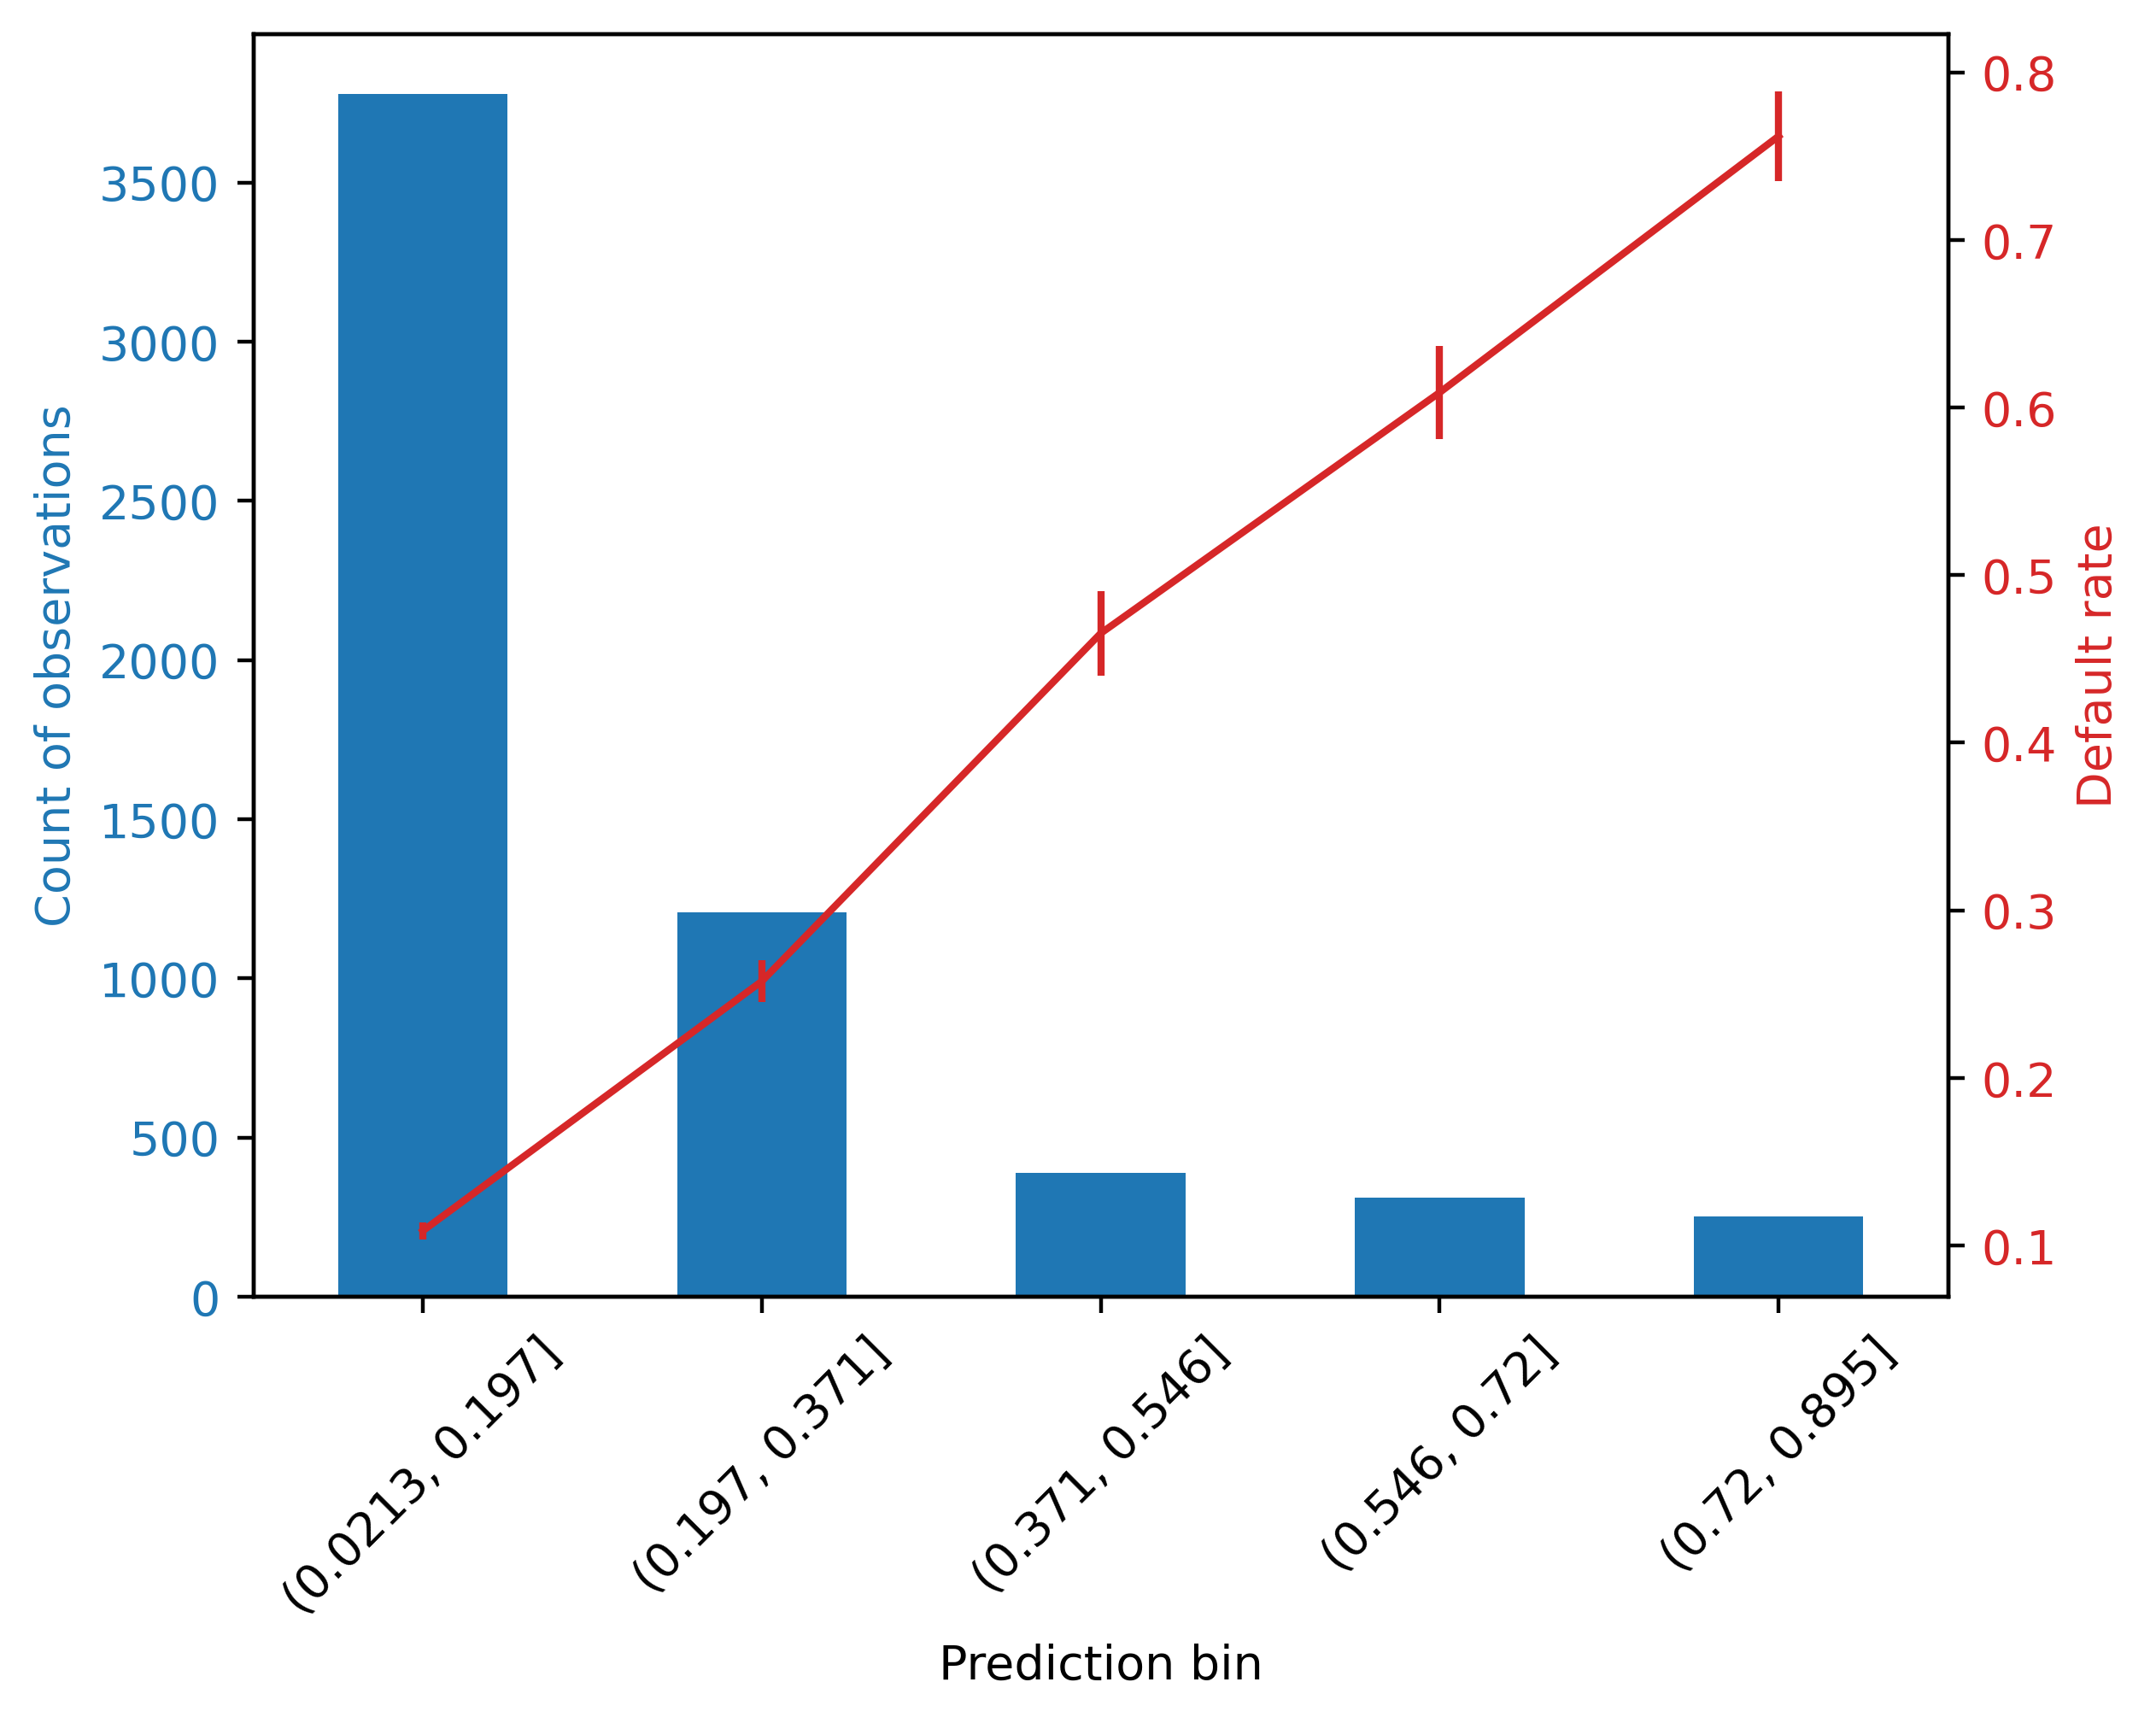

In [33]:
#Equal Interval Plot
ax_1 = plt.axes()
color_1 = 'tab:blue'
gr_eq_df[('Outcome', 'count')].plot.bar(ax=ax_1, color=color_1)
ax_1.set_ylabel('Count of observations', color=color_1)
ax_1.tick_params(axis='y', labelcolor=color_1)
ax_1.tick_params(axis='x', labelrotation = 45)
ax_2 = ax_1.twinx()
color_2 = 'tab:red'

gr_eq_df[('Outcome', 'mean')].plot(ax=ax_2, color=color_2,
yerr=std_err)
ax_2.set_ylabel('Default rate', color=color_2)
ax_2.tick_params(axis='y', labelcolor=color_2)

## Calibration of Predicted Probabilities

In [34]:
#Excpeted Calibration Error
cal_df = test_set_gr.agg({'Outcome':['count', 'mean'],'Predicted probability':'mean'})
cal_df

Outcome           Predicted probability
                    count      mean                  mean
Prediction decile                                        
(0.0211, 0.06]        594  0.045455              0.046931
(0.06, 0.0816]        594  0.070707              0.070745
(0.0816, 0.104]       594  0.099327              0.093163
(0.104, 0.127]        593  0.112985              0.115823
(0.127, 0.15]         594  0.116162              0.138657
(0.15, 0.181]         594  0.171717              0.165012
(0.181, 0.23]         593  0.195616              0.203106
(0.23, 0.322]         594  0.282828              0.273172
(0.322, 0.526]        594  0.392256              0.400159
(0.526, 0.895]        594  0.676768              0.693437

In [35]:
F = cal_df[('Outcome', 'count')].values/y_test_all.shape[0]
F

array([0.10003368, 0.10003368, 0.10003368, 0.09986527, 0.10003368,
       0.10003368, 0.09986527, 0.10003368, 0.10003368, 0.10003368])

In [36]:
#Calculate ECE
ECE = np.sum(F* np.abs(cal_df[('Outcome', 'mean')]- cal_df[('Predicted probability', 'mean')]))
ECE

0.008144502190176022

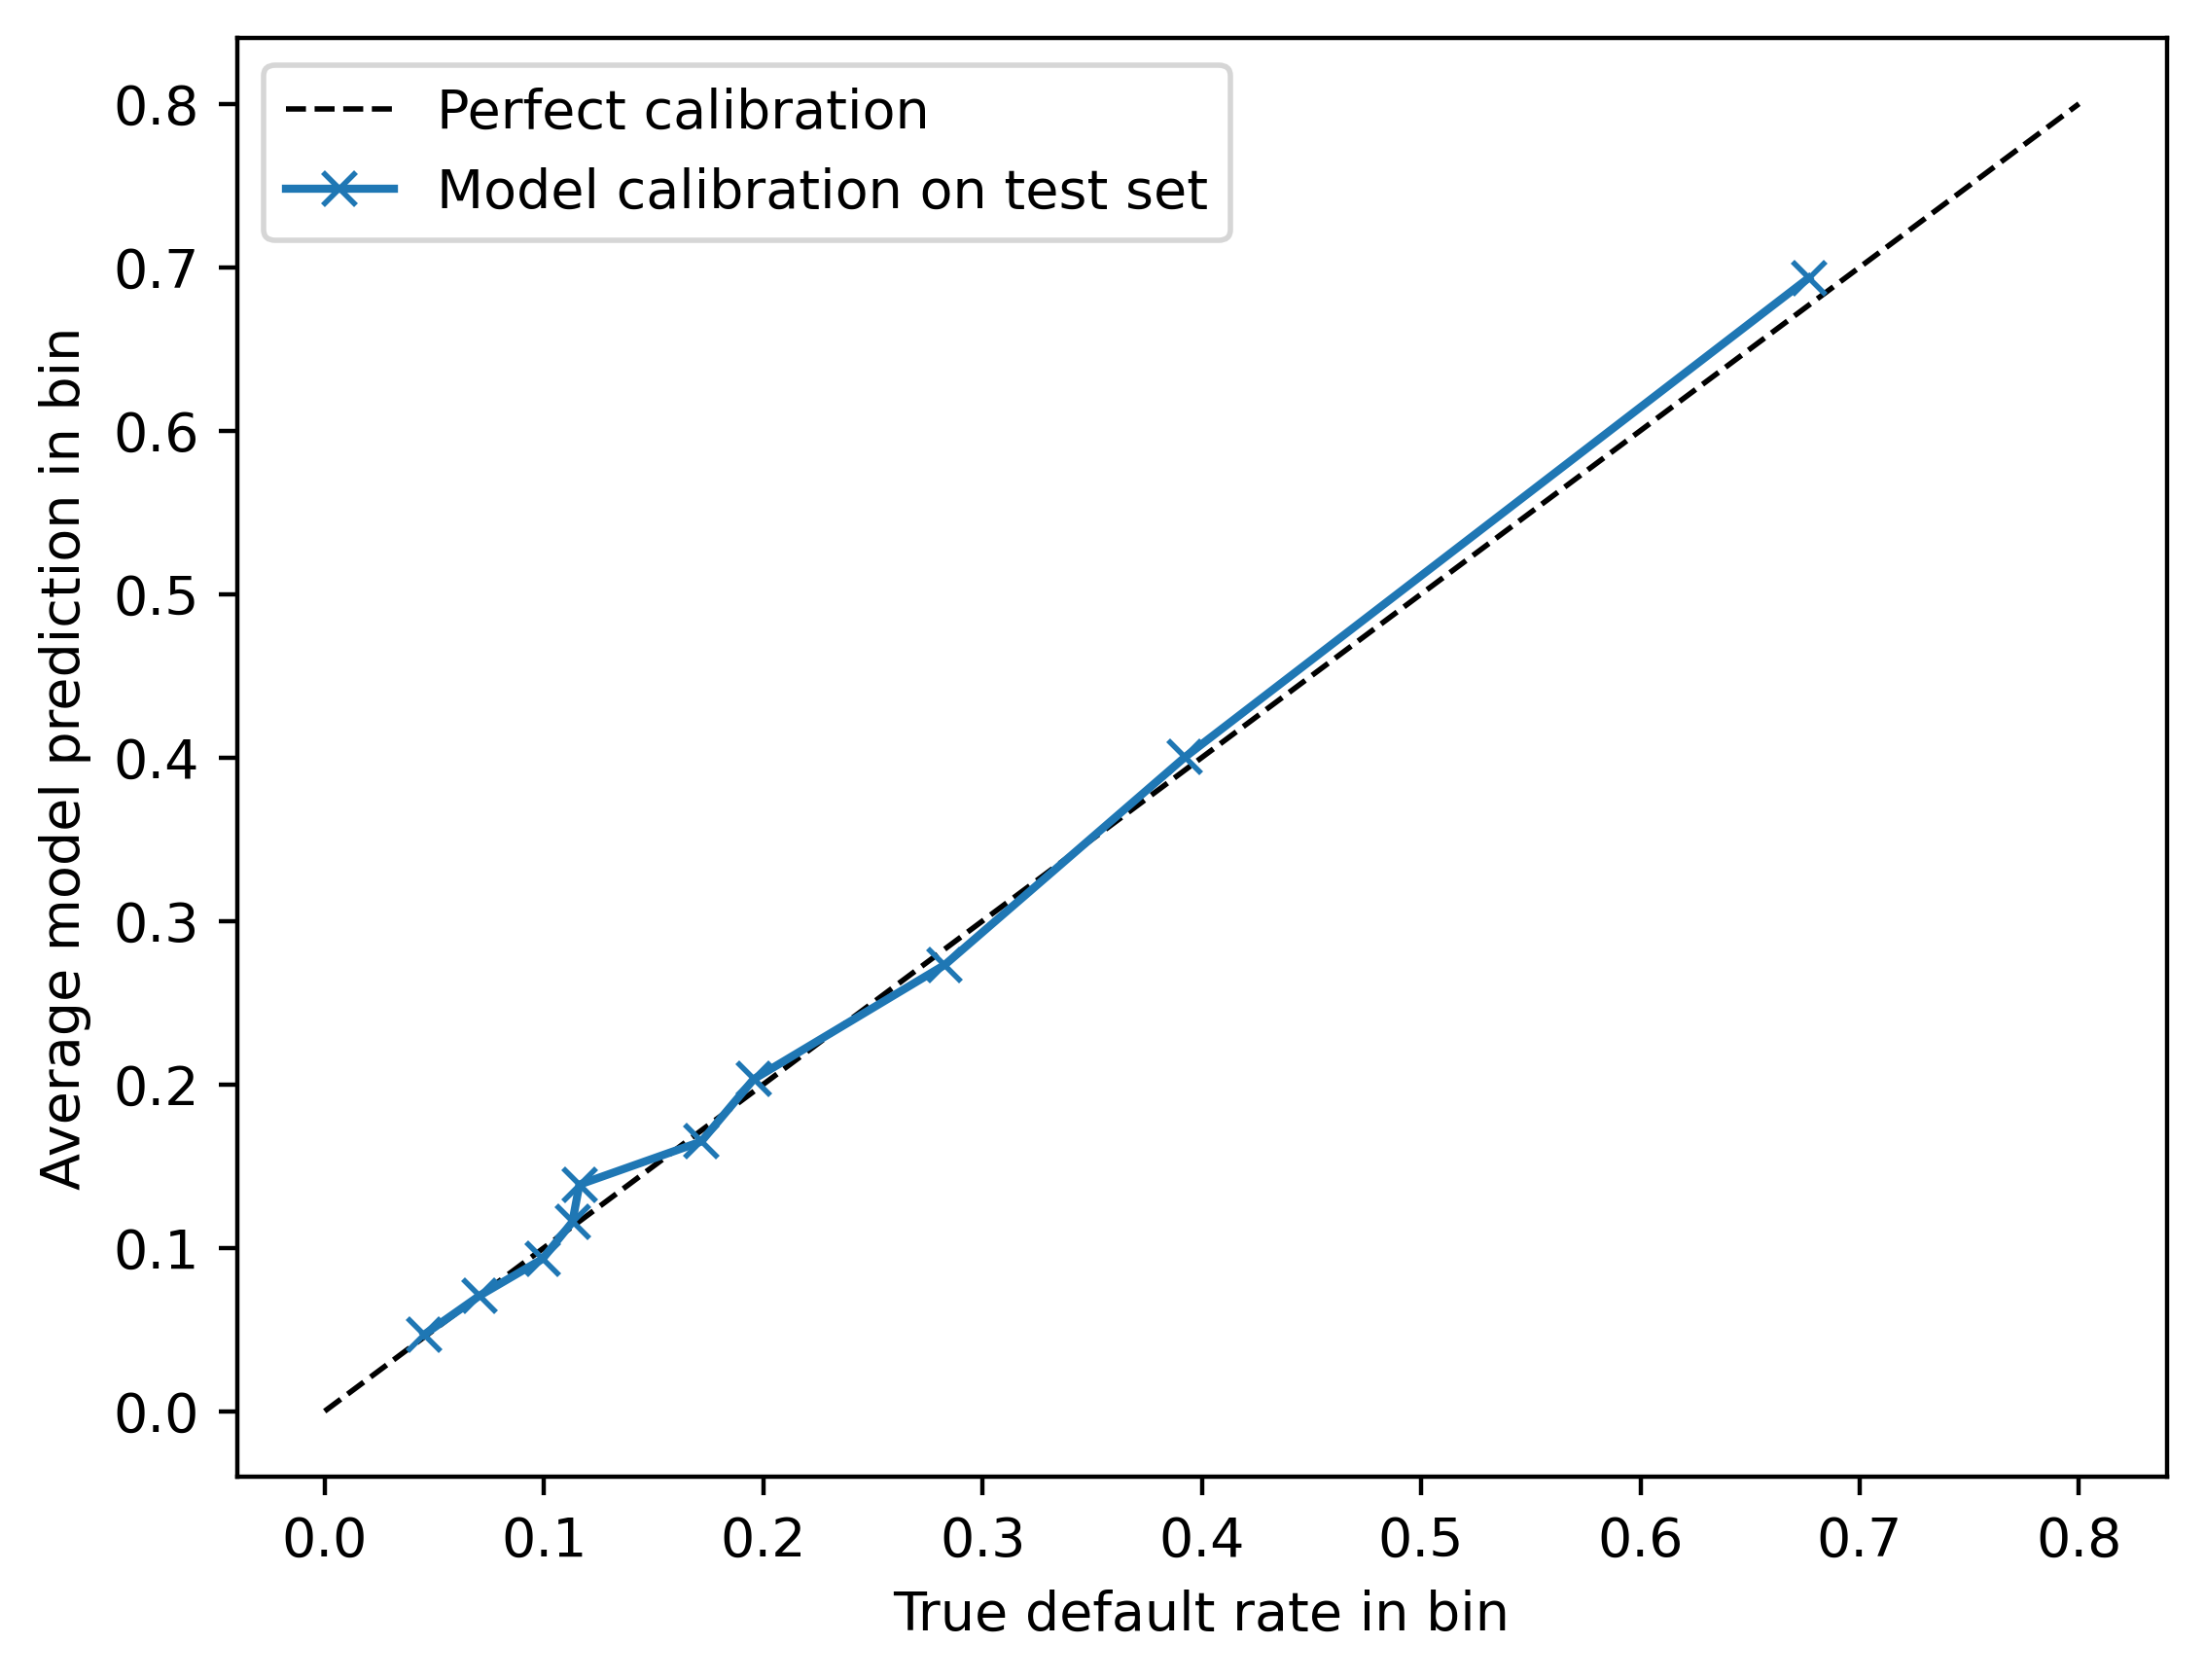

In [37]:
#Plot ECE calibration over time
ax = plt.axes()
ax.plot([0, 0.8], [0, 0.8], 'k--', linewidth=1,
label='Perfect calibration')
ax.plot(cal_df[('Outcome', 'mean')],cal_df[('Predicted probability', 'mean')],\
marker='x',label='Model calibration on test set')
ax.set_xlabel('True default rate in bin')
ax.set_ylabel('Average model prediction in bin')
ax.legend()

It's pretty well calibrated since the predicted probabilities are close to the true default rates.

## Characterising Costs and Savings

In [38]:
thresholds = np.linspace(0, 1, 101) #range of thresholds

In [39]:
features_response[5] #confirm that this is BILL_AMT1

'BILL_AMT1'

In [40]:
cost_per_counseling = 7500

In [41]:
effectiveness = 0.70

In [42]:
#Empty Arrays to store analysis results
n_pos_pred = np.empty_like(thresholds)
total_cost = np.empty_like(thresholds)
n_true_pos = np.empty_like(thresholds)
total_savings = np.empty_like(thresholds)

In [43]:
counter = 0
for threshold in thresholds:
    pos_pred = test_set_pred_proba > threshold #which accounts get positive predictions at threshold
    n_pos_pred[counter] = sum(pos_pred) #positive predictions for given threshold
    total_cost[counter] = n_pos_pred[counter] * cost_per_counseling #cost of counselling for threshold
    
    true_pos = pos_pred & y_test_all.astype(bool) #True positives
    n_true_pos[counter] = sum(true_pos) #number of true positives
    total_savings[counter] = np.sum(true_pos.astype(int)* X_test_all[:,5]* effectiveness) #Total savings
    
    counter += 1

In [44]:
net_savings = total_savings - total_cost

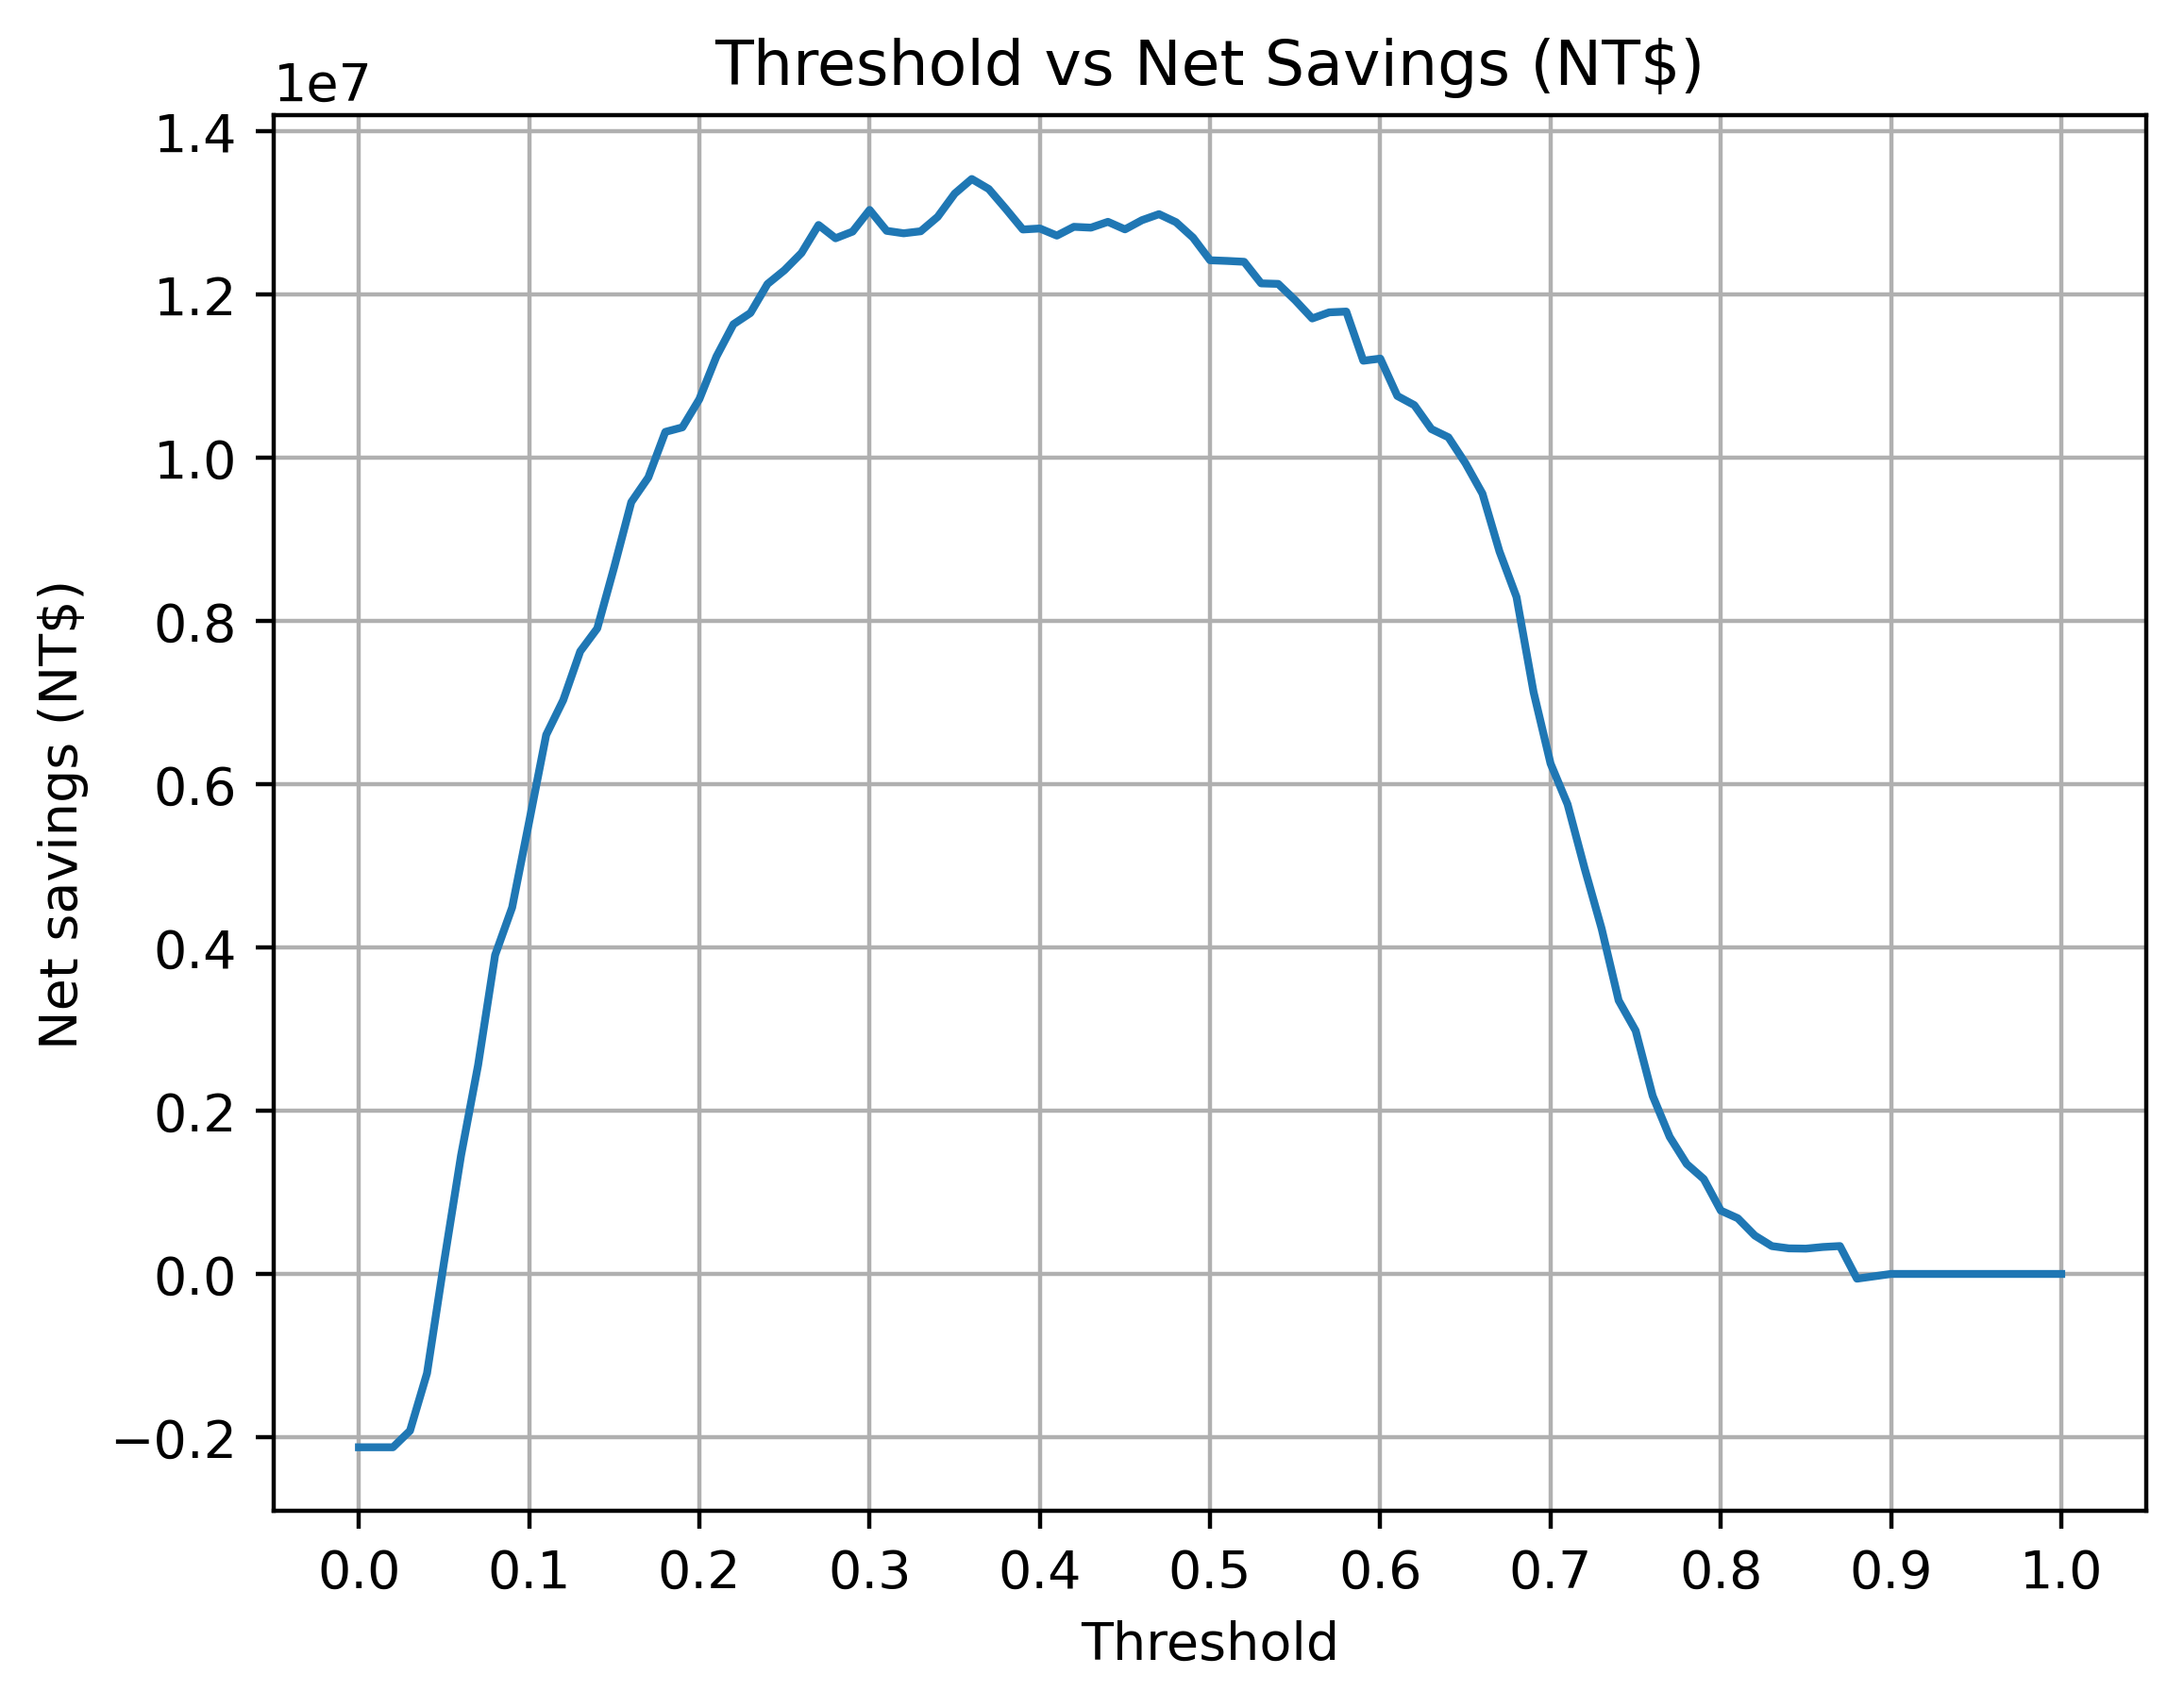

In [45]:
mpl.rcParams['figure.dpi'] = 400
plt.plot(thresholds, net_savings)
plt.xlabel('Threshold')
plt.ylabel('Net savings (NT$)')
plt.title('Threshold vs Net Savings (NT$)')
plt.xticks(np.linspace(0,1,11))
plt.grid(True)

The best savings can be found at threshold values between 0.25 and 0.5

In [46]:
#Confirm optimum threshold
max_savings_ix = np.argmax(net_savings)

thresholds[max_savings_ix]

0.36

In [47]:
net_savings[max_savings_ix] #Greatest net possible savings - OVER 13 MILLION NT$!!!

13415710.0